In [ ]:
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [241]:
class CheXpertDataset(Dataset):
    def __init__(self, data, root_dir, mode='train', transforms=None):
        self.data = data.to_numpy()
        self.labels = torch.tensor(data.values)
        self.root_dir = root_dir
        self.img_paths = [os.path.join(root_dir, img_path) for img_path in data.index]
        self.transform = transforms.get(mode)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return (image, label)
    
def get_weighted_random_sampler(data, batch_size):
    weights = 1/data.sum()
    sampler = WeightedRandomSampler(weights, batch_size, replacement=True)
    return sampler

transform = {
    'train': A.Compose([
        A.Affine(scale=(0.95, 1.05), p=0.5),
        A.OneOf([A.Affine(rotate=(-20, 20), p=0.5), A.Affine(shear=(-5, 5), p=0.5)], p=0.5),
        A.Affine(translate_percent=(-0.05, 0.05), p=0.5),
        A.Resize(224, 224),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize([0.506, 0.506, 0.506], [0.287, 0.287, 0.287]),
        ToTensorV2()
    ]),
}

In [242]:
test = pd.read_csv('/kaggle/input/chexpertsmallclean/u1_test.csv',index_col=0)
train = pd.read_csv('/kaggle/input/chexpertsmallclean/u1_train.csv', index_col=0)
val = pd.read_csv('/kaggle/input/chexpertsmallclean/u1_val.csv', index_col=0)

In [243]:
train.index =  train.index.str.replace('CheXpert-v1.0-small', 'chexpert')
test.index = test.index.str.replace('CheXpert-v1.0-small', 'chexpert')
val.index = val.index.str.replace('CheXpert-v1.0-small', 'chexpert')

In [244]:
batch_size = 32
train_dataset = CheXpertDataset(
    data=train,
    root_dir='/kaggle/input/', 
    mode='train',
    transforms = transform
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    sampler = get_weighted_random_sampler(train, batch_size),
    num_workers = 4,
    pin_memory=True
    )

/opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py:228: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights_tensor = torch.as_tensor(weights, dtype=torch.double)


In [245]:
pretrained_densenet = models.densenet121(pretrained=True)

for param in pretrained_densenet.features.parameters():
    param.requires_grad = False

# Define a new classifier with additional layers
class CustomDenseNet(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomDenseNet, self).__init__()
        
        # Retain the feature extraction part of the pre-trained DenseNet
        self.features = pretrained_model.features
        
        # Add custom convolutional layers after the DenseNet feature extractor
        self.additional_conv = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # Example additional convolutional layer
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Global average pooling (to reduce spatial dimensions before the classifier)
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Final fully connected layer (classifier), adjusted for multi-label classification
        self.classifier = nn.Linear(256, num_classes)  # 128 is the output channels from the conv layers
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Pass through the DenseNet feature extractor
        x = self.features(x)
        
        # Pass through the additional convolutional layers
        x = self.additional_conv(x)
        
        # Apply global average pooling
        x = self.pool(x)
        
        # Flatten the tensor and pass it through the classifier
        x = torch.flatten(x, 1)  # Flatten the output from the pooling layer
        x = self.classifier(x)
        return x

# Replace the DenseNet's classifier with the custom classifier
num_classes = 14
model = CustomDenseNet(pretrained_densenet, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [246]:
#model = models.densenet121(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False
#model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=14)

In [247]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.999), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                    factor = 0.1, patience = 5, mode = 'max', verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [248]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
# Wrap the training data loader with tqdm for a progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
# Forward pass: Get the logits (raw scores) from the model
        outputs = model(inputs)
# Calculate the loss: BCEWithLogitsLoss expects logits, not probabilities
        loss = loss_function(outputs, labels)
# Backward pass and optimization step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
# Print loss after each epoch
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/40: 100%|██████████| 1/1 [00:00<00:00,  2.17batch/s]


Epoch 1/40, Loss: 0.7143229434482886


Epoch 2/40: 100%|██████████| 1/1 [00:00<00:00,  2.31batch/s]


Epoch 2/40, Loss: 0.6473543217247685


Epoch 3/40: 100%|██████████| 1/1 [00:00<00:00,  2.35batch/s]


Epoch 3/40, Loss: 0.5865649964460836


Epoch 4/40: 100%|██████████| 1/1 [00:00<00:00,  2.38batch/s]


Epoch 4/40, Loss: 0.5080495504662395


Epoch 5/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 5/40, Loss: 0.451328952530665


Epoch 6/40: 100%|██████████| 1/1 [00:00<00:00,  2.35batch/s]


Epoch 6/40, Loss: 0.4041707011804517


Epoch 7/40: 100%|██████████| 1/1 [00:00<00:00,  2.43batch/s]


Epoch 7/40, Loss: 0.34829573421406423


Epoch 8/40: 100%|██████████| 1/1 [00:00<00:00,  2.36batch/s]


Epoch 8/40, Loss: 0.3480415408848785


Epoch 9/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 9/40, Loss: 0.35227526070749654


Epoch 10/40: 100%|██████████| 1/1 [00:00<00:00,  2.42batch/s]


Epoch 10/40, Loss: 0.3009801082911768


Epoch 11/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 11/40, Loss: 0.2851542198830949


Epoch 12/40: 100%|██████████| 1/1 [00:00<00:00,  2.36batch/s]


Epoch 12/40, Loss: 0.41214736128625057


Epoch 13/40: 100%|██████████| 1/1 [00:00<00:00,  2.43batch/s]


Epoch 13/40, Loss: 0.24304032583521412


Epoch 14/40: 100%|██████████| 1/1 [00:00<00:00,  2.43batch/s]


Epoch 14/40, Loss: 0.21857137729447068


Epoch 15/40: 100%|██████████| 1/1 [00:00<00:00,  2.41batch/s]


Epoch 15/40, Loss: 0.3848971590424688


Epoch 16/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 16/40, Loss: 0.19975604698993266


Epoch 17/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 17/40, Loss: 0.2914004851107685


Epoch 18/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 18/40, Loss: 0.23810543194122147


Epoch 19/40: 100%|██████████| 1/1 [00:00<00:00,  2.39batch/s]


Epoch 19/40, Loss: 0.22990589939165926


Epoch 20/40: 100%|██████████| 1/1 [00:00<00:00,  2.42batch/s]


Epoch 20/40, Loss: 0.15810772844789814


Epoch 21/40: 100%|██████████| 1/1 [00:00<00:00,  2.39batch/s]


Epoch 21/40, Loss: 0.12722364391291713


Epoch 22/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 22/40, Loss: 0.12992175809423703


Epoch 23/40: 100%|██████████| 1/1 [00:00<00:00,  2.42batch/s]


Epoch 23/40, Loss: 0.1502752238066023


Epoch 24/40: 100%|██████████| 1/1 [00:00<00:00,  2.27batch/s]


Epoch 24/40, Loss: 0.14969705520707066


Epoch 25/40: 100%|██████████| 1/1 [00:00<00:00,  2.31batch/s]


Epoch 25/40, Loss: 0.1793220250104111


Epoch 26/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 26/40, Loss: 0.14946886448563287


Epoch 27/40: 100%|██████████| 1/1 [00:00<00:00,  2.19batch/s]


Epoch 27/40, Loss: 0.1413866008950728


Epoch 28/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 28/40, Loss: 0.1253564448395699


Epoch 29/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 29/40, Loss: 0.09420581889350745


Epoch 30/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 30/40, Loss: 0.1491584469192243


Epoch 31/40: 100%|██████████| 1/1 [00:00<00:00,  2.42batch/s]


Epoch 31/40, Loss: 0.13216137761285804


Epoch 32/40: 100%|██████████| 1/1 [00:00<00:00,  2.31batch/s]


Epoch 32/40, Loss: 0.09317569178646018


Epoch 33/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 33/40, Loss: 0.09123108139803142


Epoch 34/40: 100%|██████████| 1/1 [00:00<00:00,  2.37batch/s]


Epoch 34/40, Loss: 0.0931794630375212


Epoch 35/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 35/40, Loss: 0.1054897404456483


Epoch 36/40: 100%|██████████| 1/1 [00:00<00:00,  2.40batch/s]


Epoch 36/40, Loss: 0.11164540291586685


Epoch 37/40: 100%|██████████| 1/1 [00:00<00:00,  2.39batch/s]


Epoch 37/40, Loss: 0.07050322346188814


Epoch 38/40: 100%|██████████| 1/1 [00:00<00:00,  2.39batch/s]


Epoch 38/40, Loss: 0.057865706465475696


Epoch 39/40: 100%|██████████| 1/1 [00:00<00:00,  2.35batch/s]


Epoch 39/40, Loss: 0.10684678250780572


Epoch 40/40: 100%|██████████| 1/1 [00:00<00:00,  2.31batch/s]

Epoch 40/40, Loss: 0.0691375943029381


In [249]:
test_dataset = CheXpertDataset(test, '/kaggle/input/', 
                                mode='val', transforms = transform)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 4,
    pin_memory=True)

In [250]:
model.eval()

all_labels = []  # To store all the true labels
all_preds = []  # To store all the predicted probabilities

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get the logits from the model
        outputs = model(inputs)

        # Apply sigmoid to the outputs to get probabilities
        outputs = torch.sigmoid(outputs)

        # Collect the true labels and predictions
        all_labels.append(labels.cpu().numpy())  # Convert to numpy and store
        all_preds.append(outputs.cpu().numpy())  # Convert to numpy and store

# Convert the list of arrays into a single numpy array for true labels and predictions
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Compute AUROC for multi-label classification
auroc_scores = []
for i in range(all_labels.shape[1]):  # Loop through each label
    auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])  # Calculate AUROC for each label
    auroc_scores.append(auroc)

# Calculate the mean AUROC score across all labels
mean_auroc = np.mean(auroc_scores)
print(f'Mean AUROC: {mean_auroc:.4f}')

Testing: 100%|██████████| 598/598 [00:37<00:00, 15.95batch/s]

Mean AUROC: 0.5564


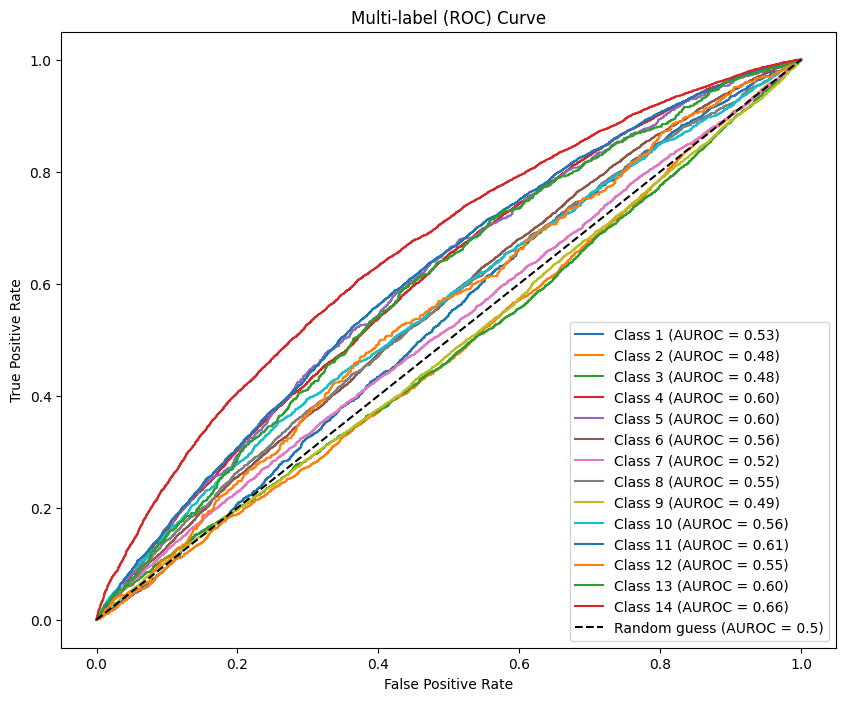

Mean AUROC across all classes: 0.56


0.5563599387717638

In [251]:
# Function to calculate and plot AUROC for multi-label classification
def plot_auroc(model, dataloader, num_classes, device):
    model.eval()
    
    true_labels = []
    predicted_probs = []
    
    # Collect true labels and predicted probabilities
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get raw model output (logits)
            outputs = model(inputs)
            
            # Apply sigmoid to get probabilities for each label
            probs = torch.sigmoid(outputs)
            
            true_labels.append(labels.cpu().numpy())
            predicted_probs.append(probs.cpu().numpy())
    
    # Convert to numpy arrays
    true_labels = np.vstack(true_labels)
    predicted_probs = np.vstack(predicted_probs)

    # Calculate AUROC for each label
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Iterate over each label and compute the ROC curve and AUROC
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = roc_auc_score(true_labels[:, i], predicted_probs[:, i])

    # Plot the ROC curve for each label
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUROC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal (random guess line)
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess (AUROC = 0.5)')
    
    # Add labels and legend
    plt.title('Multi-label (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Return mean AUROC
    mean_auroc = np.mean(list(roc_auc.values()))
    print(f'Mean AUROC across all classes: {mean_auroc:.2f}')
    return mean_auroc

model.to(device)
plot_auroc(model, test_loader, num_classes=14, device='cuda')